<a href="https://colab.research.google.com/github/MiguelEgidoMorales/APRENDIZAJE_AUTOMATICO_23_24/blob/main/LAB02_E2_GRUPO%5B3%5DV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PARTE 2

##PREPARACIÓN DATOS

In [282]:
!pip install ydata-profiling # Installs the ydata-profiling package, which includes pandas_profiling


In [283]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [284]:
data_file_path = 'firefighters_operations_madrid.csv'

data = pd.read_csv(data_file_path,  sep=';')

In [285]:
# Descripción de cada atributo

profile = ProfileReport(
    data,
    title="firefighters",
    html={'style':{'full_width':True}},
    sort= None)

profile.to_file(output_file = 'firefighters_eda.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 49.93it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [286]:
# Filtrar filas duplicadas basadas en la combinación de estas columnas

duplicated_inst = data[data.duplicated(subset=["year", "month", "district"], keep=False)]

# Visualizo
print(duplicated_inst.sort_values(by=["year", "month", "district"]).head(20))

data.drop_duplicates(subset=["year", "month", "district"], keep='first', inplace=True)


      year  month                 district  fires  construction_damages  \
1059  2022  abril               ARGANZUELA     24                     6   
1322  2022  abril               ARGANZUELA     24                     6   
1078  2022  abril                  BARAJAS      4                     0   
1341  2022  abril                  BARAJAS      4                     0   
1068  2022  abril              CARABANCHEL     27                     7   
1331  2022  abril              CARABANCHEL     27                     7   
1058  2022  abril                   CENTRO     22                    27   
1321  2022  abril                   CENTRO     22                    27   
1062  2022  abril                CHAMARTIN     13                     8   
1325  2022  abril                CHAMARTIN     13                     8   
1064  2022  abril                 CHAMBERI     13                    13   
1327  2022  abril                 CHAMBERI     13                    13   
1072  2022  abril        

In [287]:
# valores por año y valores de risk faltantes por año
value_years = data['year'].value_counts()
missing_years = data[data['risk'].isnull()]['year'].value_counts()

print('Valores por año', value_years)
print('Faltantes por año', missing_years)

Valores por año year
2024    264
2023    264
2022    263
2019    259
2018    258
2021    258
2017    107
Name: count, dtype: int64
Faltantes por año year
2024    264
Name: count, dtype: int64


In [288]:
# Eliminar los valores del 2024 a los que les falta el riesgo
data.dropna(subset=['risk'], inplace=True)

In [289]:
# Mostrar los valores únicos en la columna 'month'
print(data['month'].unique())

['Agosto' 'Septiembre' 'Octubre' 'Noviembre' 'Diciembre' 'Enero' 'Febrero'
 'Marzo' 'Abril' 'Mayo' 'Junio' 'Julio' 'diciembre' 'noviembre' 'octubre'
 'septiembre' 'agosto' 'julio' 'junio' 'mayo' 'abril' 'marzo' 'febrero'
 'enero']


In [290]:
# Reemplazar nombres de meses para estandarización
data['month'].replace(
    ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
    inplace=True
)

<ipython-input-290-6f79abf2c82e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['month'].replace(


In [291]:
# Función para categorizar una columna según umbrales dados
def categorize_column(column, none_max, low_max, medium_max):
    categories = []
    for value in column:
        if value <= none_max:
            categories.append('None_' + column.name)
        elif value <= low_max:
            categories.append('Low_' + column.name)
        elif value <= medium_max:
            categories.append('Medium_' + column.name)
        else:
            categories.append('High_' + column.name)
    return categories


# Aplicar la categorización a varias columnas del DataFrame
data["fires_category"] = categorize_column(data["fires"], 0, 4, 10)
data["construction_damages_category"] = categorize_column(data["construction_damages"], 0, 4, 10)
data["rescues_and_savings_category"] = categorize_column(data["rescues_and_savings"], 0, 4, 10)
data["water_damages_category"] = categorize_column(data["water_damages"], 0, 4, 10)
data["various_incidents_category"] = categorize_column(data["various_incidents"], 0, 4, 10)
data["non_intervention_calls_category"] = categorize_column(data["non_intervention_calls"], 0, 4, 10)
data["various_services_category"] = categorize_column(data["various_services"], 0, 4, 10)
data["risk_category"] = categorize_column(data["risk"], 0, 10, 100)

In [292]:
# Creación de la lista de transacciones
data_transactions = data.drop(columns=['fires', 'construction_damages', 'rescues_and_savings',
                                       'water_damages', 'various_incidents', 'non_intervention_calls',
                                       'various_services', 'risk'], inplace=False)

data_transactions['year'] = data_transactions['year'].astype(str)

# Mostrar las primeras filas de data_transactions
print(data_transactions.head())

# Convertir el DataFrame a una lista de listas
list_transactions = data_transactions.to_numpy().tolist()

# Mostrar una parte de la lista de transacciones
print(list_transactions[1:5][:])  # Mostrar los primeros 5 elementos

# Verificar el tipo de la lista generada
print(type(list_transactions))

# Imprimir la cantidad total de transacciones en la lista
print(len(list_transactions))
print(len(list_transactions[0]))


   year   month    district fires_category construction_damages_category  \
0  2017  Agosto      CENTRO     High_fires     High_construction_damages   
1  2017  Agosto  ARGANZUELA     High_fires   Medium_construction_damages   
2  2017  Agosto      RETIRO     High_fires   Medium_construction_damages   
3  2017  Agosto   SALAMANCA     High_fires     High_construction_damages   
4  2017  Agosto   CHAMARTIN     High_fires   Medium_construction_damages   

  rescues_and_savings_category water_damages_category  \
0     High_rescues_and_savings     High_water_damages   
1     High_rescues_and_savings     High_water_damages   
2     High_rescues_and_savings   Medium_water_damages   
3     High_rescues_and_savings     High_water_damages   
4     High_rescues_and_savings   Medium_water_damages   

  various_incidents_category non_intervention_calls_category  \
0     High_various_incidents     High_non_intervention_calls   
1     High_various_incidents     High_non_intervention_calls   
2     Hi

## 2.Generación del modelo de predicción

###2.1 Crea dos conjuntos de instancias: (1) el conjunto de entrenamiento para entrenar tus modelos; y (2)el conjunto de prueba para evaluar tu modelo.

In [293]:
data_transactions.head()

,year,month,district,fires_category,construction_damages_category,rescues_and_savings_category,water_damages_category,various_incidents_category,non_intervention_calls_category,various_services_category,risk_category
0,2017,Agosto,CENTRO,High_fires,High_construction_damages,High_rescues_and_savings,High_water_damages,High_various_incidents,High_non_intervention_calls,Medium_various_services,High_risk
1,2017,Agosto,ARGANZUELA,High_fires,Medium_construction_damages,High_rescues_and_savings,High_water_damages,High_various_incidents,High_non_intervention_calls,Low_various_services,High_risk
2,2017,Agosto,RETIRO,High_fires,Medium_construction_damages,High_rescues_and_savings,Medium_water_damages,High_various_incidents,Low_non_intervention_calls,Low_various_services,Medium_risk
3,2017,Agosto,SALAMANCA,High_fires,High_construction_damages,High_rescues_and_savings,High_water_damages,High_various_incidents,Low_non_intervention_calls,Low_various_services,High_risk
4,2017,Agosto,CHAMARTIN,High_fires,Medium_construction_damages,High_rescues_and_savings,Medium_water_damages,High_various_incidents,High_non_intervention_calls,Low_various_services,Medium_risk


In [294]:
#eliminar year month y district
data_transactions.drop(columns=['year', 'month', 'district'], inplace=True)

In [295]:
data_transactions['fires_category'] = data_transactions['fires_category'].replace(['None_fires', 'Low_fires', 'Medium_fires', 'High_fires'], [0, 1, 2, 3])


data_transactions['construction_damages_category'] = data_transactions['construction_damages_category'].replace(
    ['None_construction_damages', 'Low_construction_damages', 'Medium_construction_damages', 'High_construction_damages'],
    [0, 1, 2, 3]
)

data_transactions['rescues_and_savings_category'] = data_transactions['rescues_and_savings_category'].replace(
    ['None_rescues_and_savings', 'Low_rescues_and_savings', 'Medium_rescues_and_savings', 'High_rescues_and_savings'],
    [0, 1, 2, 3]
)

data_transactions['water_damages_category'] = data_transactions['water_damages_category'].replace(
    ['None_water_damages', 'Low_water_damages', 'Medium_water_damages', 'High_water_damages'],
    [0, 1, 2, 3]
)

data_transactions['various_incidents_category'] = data_transactions['various_incidents_category'].replace(
    ['None_various_incidents', 'Low_various_incidents', 'Medium_various_incidents', 'High_various_incidents'],
    [0, 1, 2, 3]
)

data_transactions['non_intervention_calls_category'] = data_transactions['non_intervention_calls_category'].replace(
    ['None_non_intervention_calls', 'Low_non_intervention_calls', 'Medium_non_intervention_calls', 'High_non_intervention_calls'],
    [0, 1, 2, 3]
)

data_transactions['various_services_category'] = data_transactions['various_services_category'].replace(
    ['None_various_services', 'Low_various_services', 'Medium_various_services', 'High_various_services'],
    [0, 1, 2, 3]
)

data_transactions['risk_category'] = data_transactions['risk_category'].replace(
    ['None_risk', 'Low_risk', 'Medium_risk', 'High_risk'],
    [0, 1, 2, 3]
)

<ipython-input-295-5190a0e0a3f4>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_transactions['fires_category'] = data_transactions['fires_category'].replace(['None_fires', 'Low_fires', 'Medium_fires', 'High_fires'], [0, 1, 2, 3])
<ipython-input-295-5190a0e0a3f4>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_transactions['construction_damages_category'] = data_transactions['construction_damages_category'].replace(
<ipython-input-295-5190a0e0a3f4>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and w

In [296]:
x_df = data_transactions.drop(columns=['risk_category'])
y_df = data_transactions['risk_category']

In [297]:
x_df.head()

,fires_category,construction_damages_category,rescues_and_savings_category,water_damages_category,various_incidents_category,non_intervention_calls_category,various_services_category
0,3,3,3,3,3,3,2
1,3,2,3,3,3,3,1
2,3,2,3,2,3,1,1
3,3,3,3,3,3,1,1
4,3,2,3,2,3,3,1


In [298]:
y_df.head()

,risk_category
0,3
1,3
2,2
3,3
4,2


In [299]:
#Creo el dataset de entrenamiento y el de test (30%)
X_train_df, X_test_df, y_train_df, y_test_df= train_test_split(x_df,y_df,test_size=0.3, random_state=42)

In [300]:
print('X:',X_train_df.shape, X_test_df.shape)
print('y:',y_train_df.shape, y_test_df.shape)

X: (986, 7) (423, 7)
y: (986,) (423,)


###2.2Construye diferentes modelos de clasificación utilizando al menos dos criterios de división distintos o medidas de desorden. Para cada clasificador, debes calcular el error de clasificación.


####2.2.1 ENTROPIA

In [301]:
modelo_entropy = DecisionTreeClassifier(criterion="entropy",splitter = 'best')
modelo_entropy.fit(X_train_df, y_train_df)

DecisionTreeClassifier(criterion='entropy')

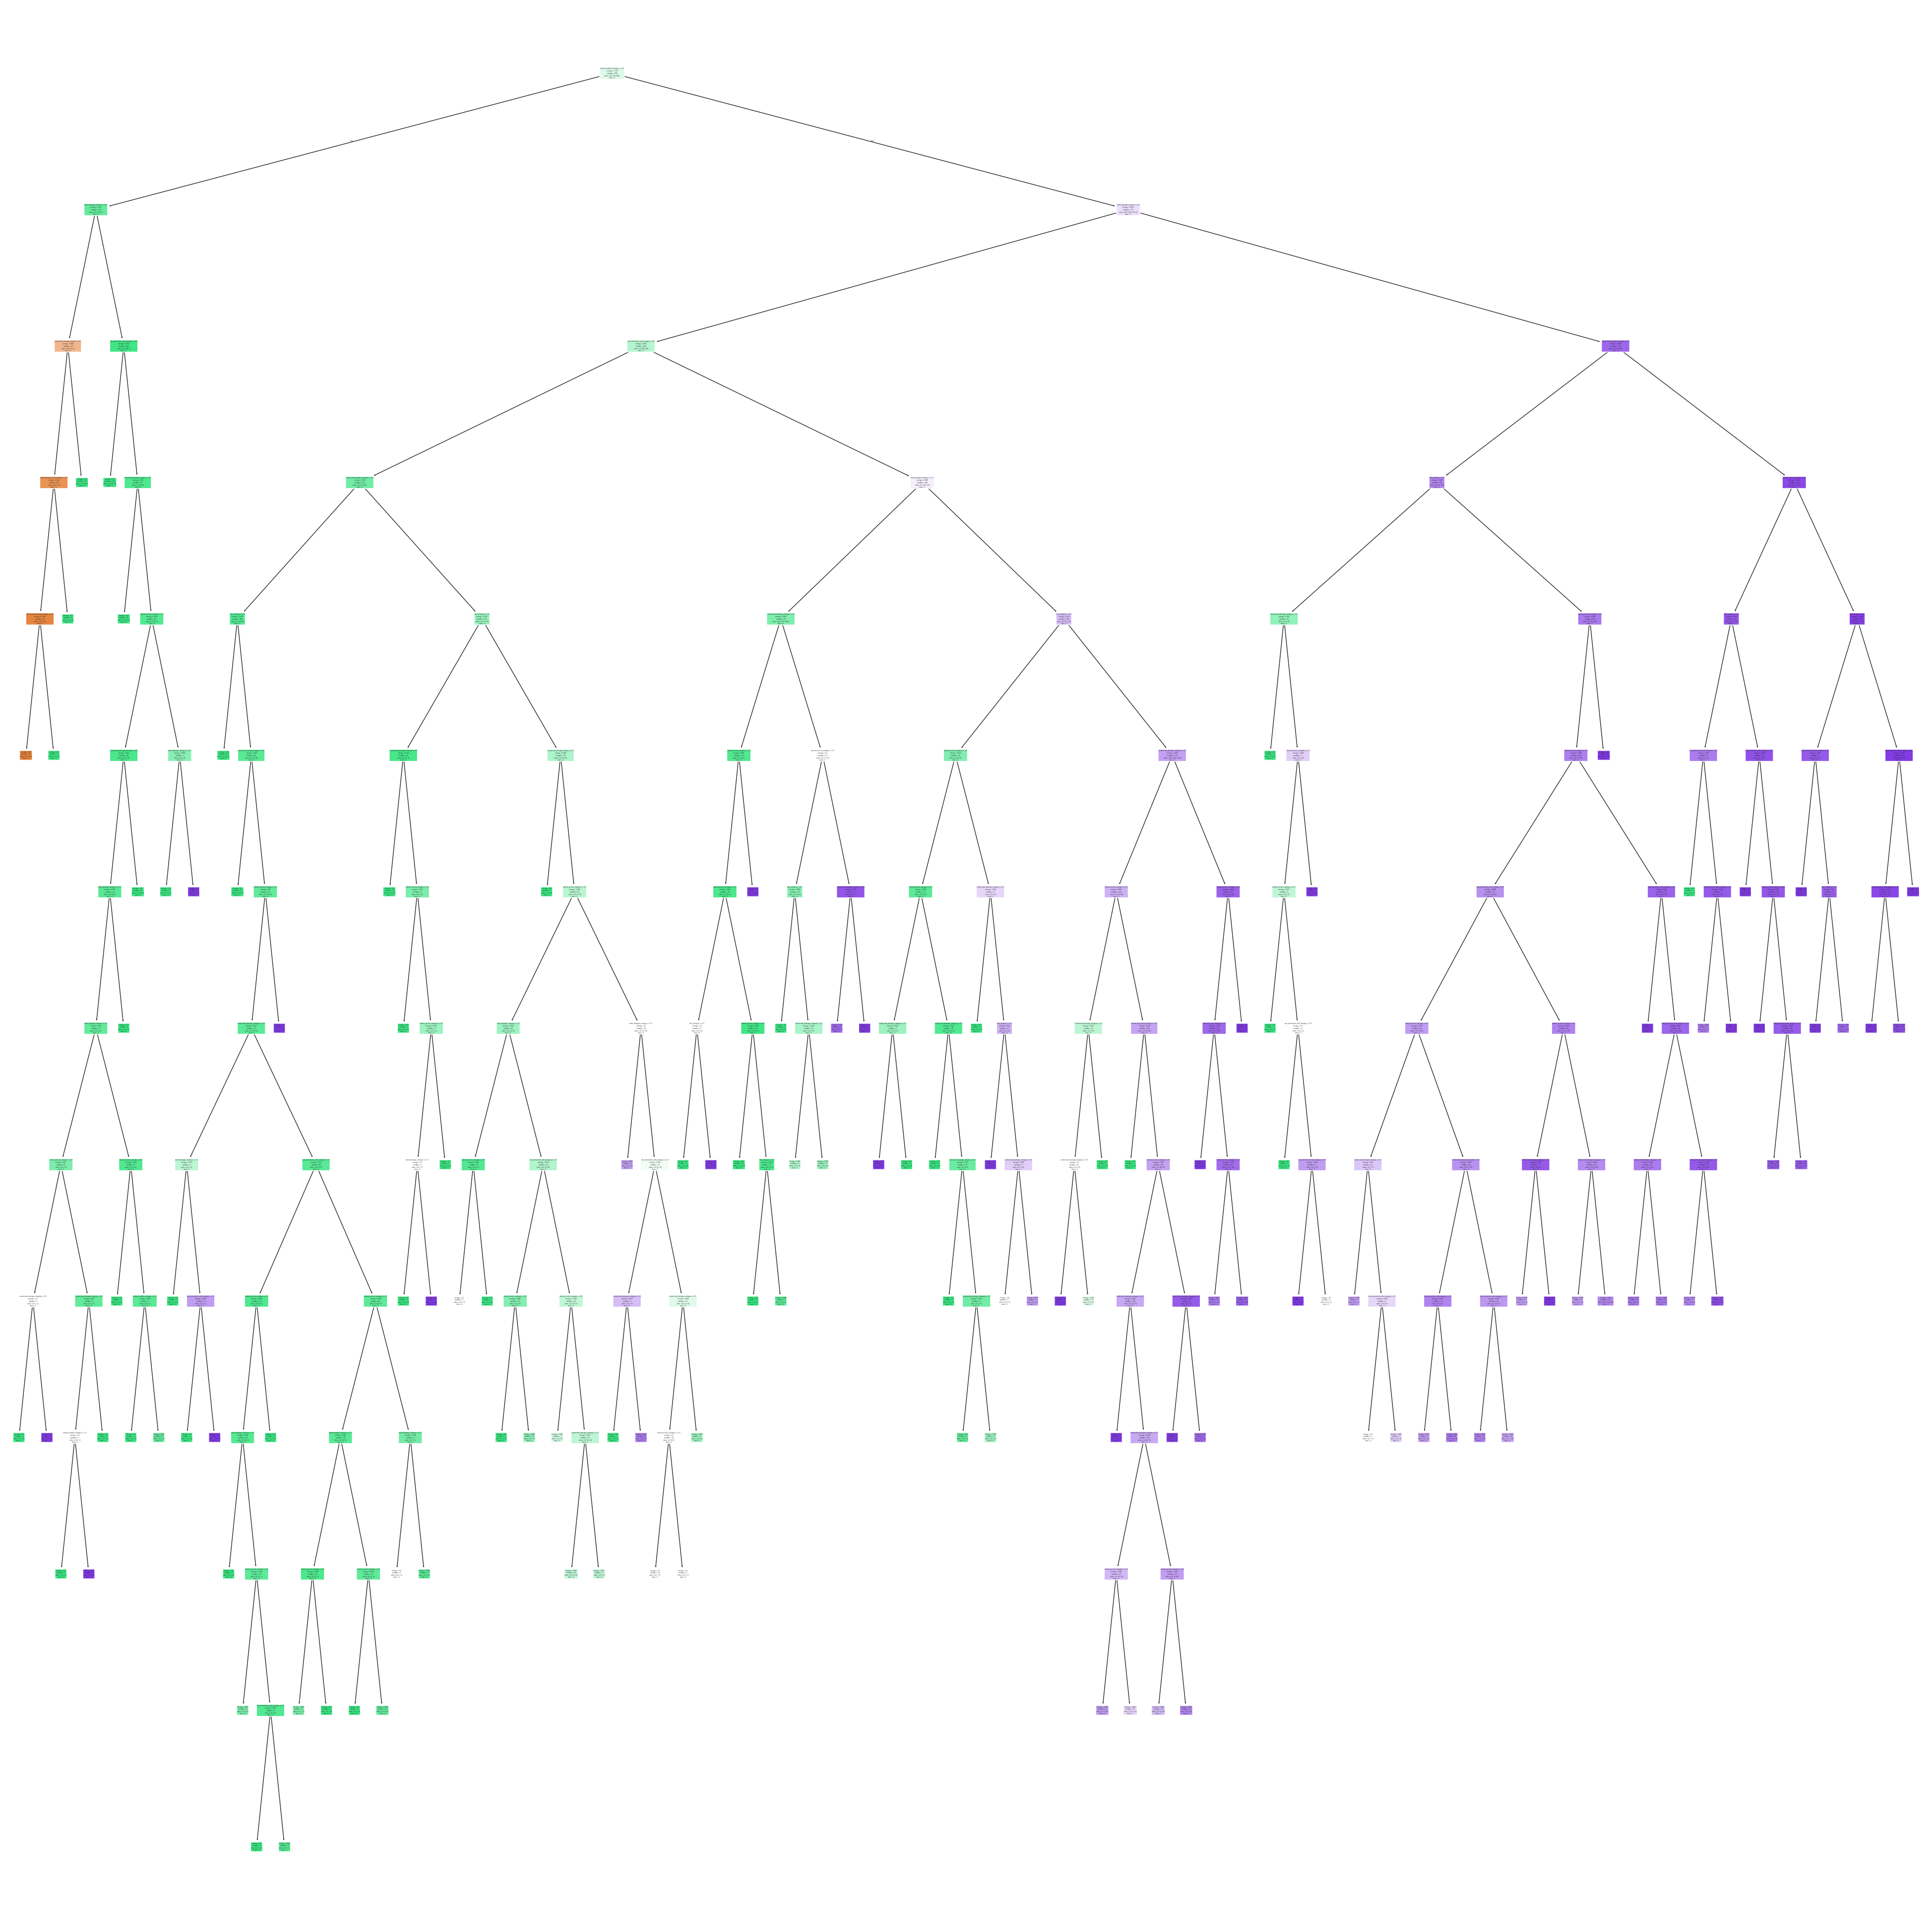

In [327]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Graficar el árbol de decisión con Entropía
plt.figure(figsize=(50, 50))
plot_tree(modelo_entropy, feature_names=x_df.columns, class_names=y_df.unique().astype(str), filled=True, rounded=True)
plt.show()



In [303]:
y_pred_entropy = modelo_entropy.predict(X_test_df)

In [304]:
print("Resultados con Entropía:")
print(classification_report(y_test_df, y_pred_entropy))
print("Exactitud:", accuracy_score(y_test_df, y_pred_entropy))

Resultados con Entropía:
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.79      0.75      0.77       217
           3       0.74      0.78      0.76       196

    accuracy                           0.77       423
   macro avg       0.78      0.81      0.79       423
weighted avg       0.77      0.77      0.77       423

Exactitud: 0.7659574468085106


In [305]:
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
cm = confusion_matrix(y_test_df, y_pred_entropy)

# Mostrar la matriz de confusión
print("Matriz de Confusión para Entropía:")
print(cm)

Matriz de Confusión para Entropía:
[[  9   1   0]
 [  2 162  53]
 [  0  43 153]]


####2.2.2. GINI

In [306]:
modelo_gini = DecisionTreeClassifier(criterion="gini",splitter = 'best')
modelo_gini.fit(X_train_df, y_train_df)

DecisionTreeClassifier()

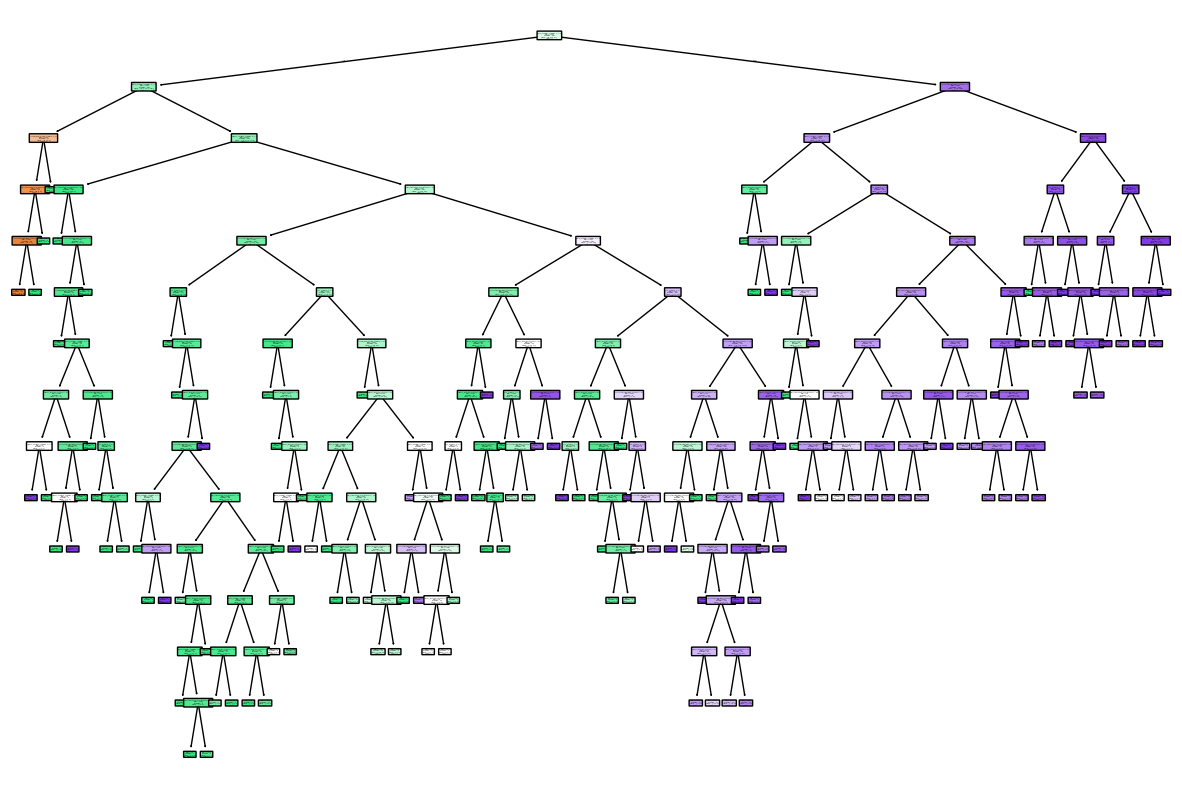

In [307]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Graficar el árbol de decisión con Entropía
plt.figure(figsize=(15, 10))
plot_tree(modelo_gini, feature_names=x_df.columns, class_names=y_df.unique().astype(str), filled=True, rounded=True)
plt.show()

In [308]:

y_pred_gini = modelo_gini.predict(X_test_df)

In [309]:
print("\nResultados con Gini:")
print(classification_report(y_test_df, y_pred_gini))
print("Exactitud:", accuracy_score(y_test_df, y_pred_gini))


Resultados con Gini:
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.79      0.75      0.77       217
           3       0.75      0.78      0.76       196

    accuracy                           0.77       423
   macro avg       0.78      0.81      0.80       423
weighted avg       0.77      0.77      0.77       423

Exactitud: 0.7683215130023641


In [310]:
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
cm = confusion_matrix(y_test_df, y_pred_gini)

# Mostrar la matriz de confusión
print("Matriz de Confusión para Entropía:")
print(cm)

Matriz de Confusión para Entropía:
[[  9   1   0]
 [  2 163  52]
 [  0  43 153]]


 ####2.2.3. RANDOM FOREST

In [311]:
!pip install ydata-profiling

In [312]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00


In [313]:
from pandas_profiling import ProfileReport
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
sns.set(style='whitegrid', context='notebook')

In [314]:
#Creo el random forest, n_estimators es el número de árboles de decisión que lo van a formar
rfc_df = RandomForestClassifier(n_estimators=21)

In [315]:
#Entreno con los datos de entrenamiento
rfc_df.fit(X_train_df,y_train_df)

RandomForestClassifier(n_estimators=21)

In [316]:
#Hago predicciones sobre test y train
y_pred_test_rf = rfc_df.predict(X_test_df)
y_pred_train_rf = rfc_df.predict(X_train_df)

In [317]:
#Calculo la matriz de confusión sobre los datos de test
cm = confusion_matrix(y_test_df, y_pred_test_rf)

<Axes: >

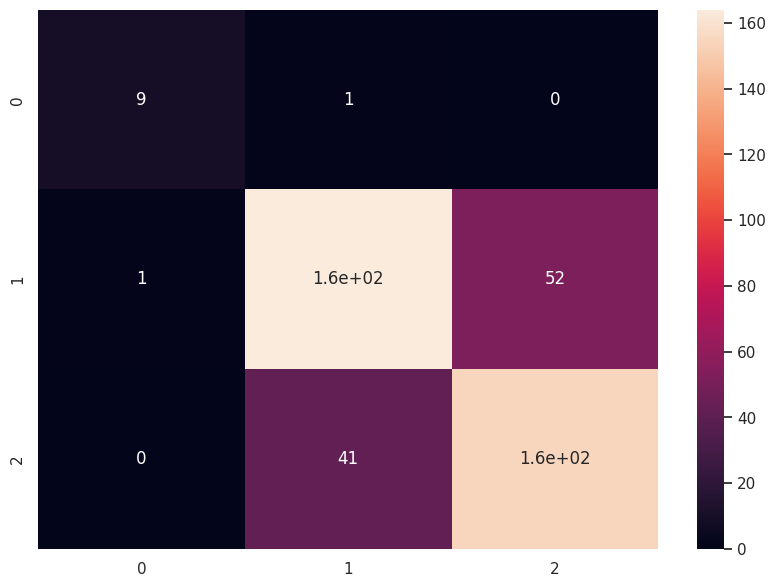

In [321]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [326]:
#Obtengo métricas de evaluación sobre los datos de test
print(classification_report(y_test_df,y_pred_test_rf))
print("Exactitud:", accuracy_score(y_test_df, y_pred_test_rf))

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        10
           2       0.80      0.76      0.78       217
           3       0.75      0.79      0.77       196

    accuracy                           0.78       423
   macro avg       0.81      0.82      0.81       423
weighted avg       0.78      0.78      0.78       423

Exactitud: 0.7754137115839244


In [324]:
print(accuracy_score(y_train_df,y_pred_train_rf))
print(accuracy_score(y_test_df,y_pred_test_rf))

0.8438133874239351
0.7754137115839244


<Figure size 3000x3000 with 0 Axes>

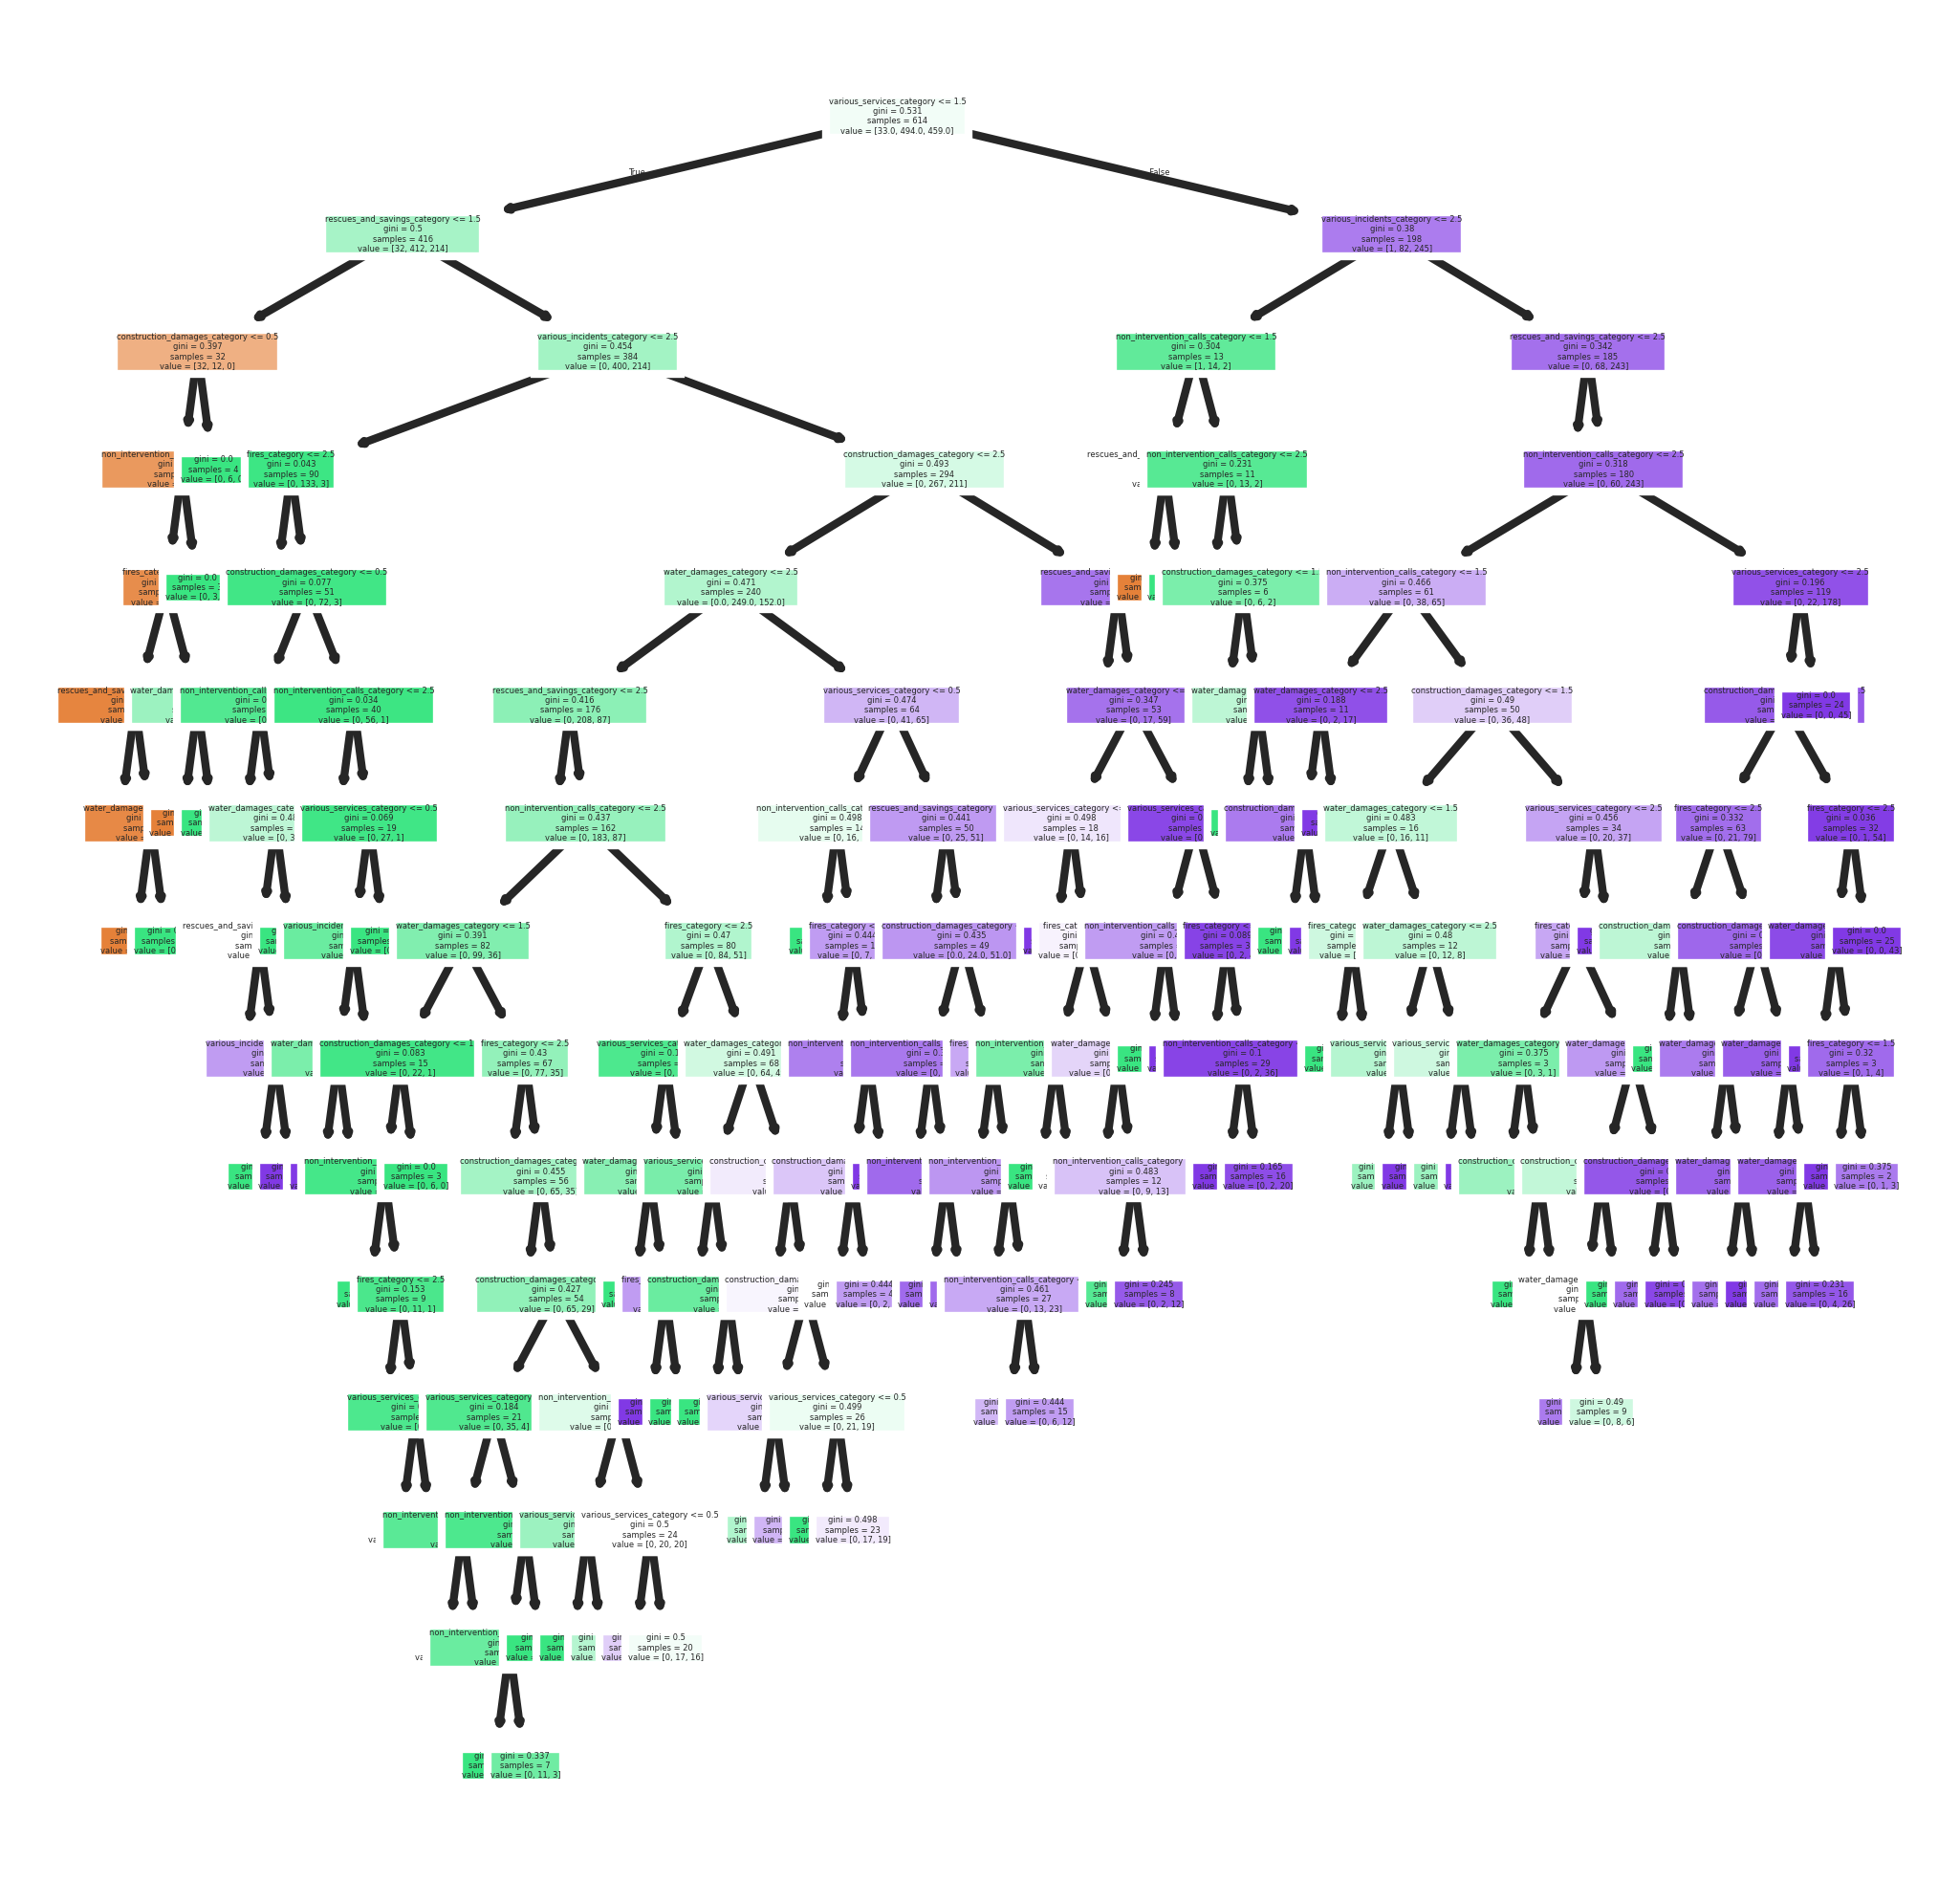

In [325]:
plt.figure(figsize=(30, 30))

# Obtener un árbol aleatorio del Random Forest
tree_index = 0  # Índice del árbol deseado
Tree = rfc_df.estimators_[tree_index]

# Visualizar el árbol utilizando plot_tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(Tree, feature_names=X_train_df.columns, filled=True)
plt.savefig('tree.png')